In [ ]:
!pip install torch_geometric

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import networkx as nx
import csv
from torch_geometric.loader import DataLoader
from datetime import datetime

from utils import preprocess_dataset, construct_nx_from_adj
from autoencoder import VariationalAutoEncoder, sample_from_latent_space
from da_utils import calculate_stats_graph
from sklearn.metrics import mean_absolute_error
from da_utils import get_train_and_valid_data_df, global_statistics

# Configuration

In [256]:
# Define parameters as a dictionary
config = {
    "lr": 1e-3,
    "dropout": 0.0,
    "batch_size": 64,
    "epochs_autoencoder": 200,
    "hidden_dim_encoder": 128,
    "hidden_dim_decoder": 256,
    "latent_dim": 64,
    "n_max_nodes": 50,
    "n_layers_encoder": 4,
    "n_layers_decoder": 6,
    "spectral_emb_dim": 10,
    "train_autoencoder": True,
    "n_condition": 7, 
    "alt_encoder_loss": False, 
    "keep_exact_cond": True,
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)

# Preprocess train, validation, and test datasets
trainset = preprocess_dataset("train", config["n_max_nodes"], config["spectral_emb_dim"])
validset = preprocess_dataset("valid", config["n_max_nodes"], config["spectral_emb_dim"])
testset = preprocess_dataset("test", config["n_max_nodes"], config["spectral_emb_dim"])

# Initialize data loaders
train_loader = DataLoader(trainset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(validset, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(testset, batch_size=config["batch_size"], shuffle=False)

Using device:  cpu


c:\Users\fredh\OneDrive\Documents\MVA\S1\ALTEGRAD\altegrad_challenge_code\src\utils.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


Dataset ../data/dataset_train.pt loaded from file
Dataset ../data/dataset_valid.pt loaded from file
Dataset ../data/dataset_test.pt loaded from file


c:\Users\fredh\OneDrive\Documents\MVA\S1\ALTEGRAD\altegrad_challenge_code\src\utils.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


# Model

In [257]:
# Initialize VGAE model
autoencoder = VariationalAutoEncoder(
    input_dim=config["spectral_emb_dim"] + 1,
    hidden_dim_enc=config["hidden_dim_encoder"],
    hidden_dim_dec=config["hidden_dim_decoder"],
    latent_dim=config["latent_dim"],
    n_layers_enc=config["n_layers_encoder"],
    n_layers_dec=config["n_layers_decoder"],
    n_max_nodes=config["n_max_nodes"],
    n_condition=config["n_condition"],
    keep_exact_cond=config["keep_exact_cond"],
    alt_loss=config["alt_encoder_loss"],
).to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=config["lr"], weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.6)
trainable_params_autoenc = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print("Number of Autoencoder's trainable parameters: "+str(trainable_params_autoenc))

Number of Autoencoder's trainable parameters: 997138


# Training

In [ ]:
if config["train_autoencoder"]:
    best_val_loss = np.inf
    for epoch in range(1, config["epochs_autoencoder"] + 1):
        autoencoder.train()
        train_loss_all = 0
        train_count = 0
        train_loss_all_recon = 0
        train_loss_all_kld = 0
        cnt_train = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            loss, recon, kld = autoencoder.loss_function(data, epoch)
            train_loss_all_recon += recon.item()
            train_loss_all_kld += kld.item()
            cnt_train += 1
            loss.backward()
            train_loss_all += loss.item()
            train_count += torch.max(data.batch) + 1
            optimizer.step()

        autoencoder.eval()
        val_loss_all = 0
        val_count = 0
        cnt_val = 0
        val_loss_all_recon = 0
        val_loss_all_kld = 0

        for data in val_loader:
            data = data.to(device)
            loss, recon, kld = autoencoder.loss_function(data, epoch)
            val_loss_all_recon += recon.item()
            val_loss_all_kld += kld.item()
            val_loss_all += loss.item()
            cnt_val += 1
            val_count += torch.max(data.batch) + 1

        if epoch % 10 == 0:
            dt_t = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
            print(f'{dt_t} Epoch: {epoch:04d}, Train Loss: {train_loss_all/cnt_train:.5f}, Train Reconstruction Loss: {train_loss_all_recon/cnt_train:.2f}, Train KLD Loss: {train_loss_all_kld/cnt_train:.2f}')
            print(f'{dt_t} Epoch: {epoch:04d}, Val Loss: {val_loss_all/cnt_val:.5f}, Val Reconstruction Loss: {val_loss_all_recon/cnt_val:.2f}, Val KLD Loss: {val_loss_all_kld/cnt_val:.2f}')

        if epoch % 20 == 0:
            print('beta', autoencoder.beta)
        
        if epoch % 150 == 0:
            print('lr: ', optimizer.param_groups[-1]['lr'])
        scheduler.step()

        if best_val_loss >= val_loss_all:
            best_val_loss = val_loss_all

            torch.save({
                'state_dict': autoencoder.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, 'autoencoder.pth.tar')
else:
    checkpoint = torch.load('autoencoder.pth.tar')
    autoencoder.load_state_dict(checkpoint['state_dict'])
print('Training finished')

# Evaluate on Validation

In [ ]:
checkpoint = torch.load('autoencoder.pth.tar')
autoencoder.load_state_dict(checkpoint['state_dict'])
autoencoder.eval()
val_loss_all = 0
val_count = 0
cnt_val = 0
val_loss_all_recon = 0
val_loss_all_kld = 0

for data in val_loader:
    data = data.to(device)
    loss, recon, kld = autoencoder.loss_function(data, 3)
    val_loss_all_recon += recon.item()
    val_loss_all_kld += kld.item()
    val_loss_all += loss.item()
    cnt_val += 1
    val_count += torch.max(data.batch) + 1
print(f'{dt_t} Epoch: {epoch:04d}, Val Loss: {val_loss_all/cnt_val:.5f}, Val Reconstruction Loss: {val_loss_all_recon/cnt_val:.2f}, Val KLD Loss: {val_loss_all_kld/cnt_val:.2f}')

# Generate Test Graphs

In [ ]:
checkpoint = torch.load('autoencoder.pth.tar')
autoencoder.load_state_dict(checkpoint['state_dict'])
autoencoder.eval()

Graphs = []
with open("output_vgae.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write the header
    writer.writerow(["graph_id", "edge_list"])
    for k, data in enumerate(tqdm(test_loader, desc='Processing test set',)):
            data = data.to(device)
            
            stats = data.stats
            bs = stats.size(0)
    
            graph_ids = data.filename
        
            adj = sample_from_latent_space(autoencoder, latent_dim=config["latent_dim"], c=stats, device=device)
            for i in range(bs):
    
                Gs_generated = construct_nx_from_adj(adj[i,:,:].detach().cpu().numpy())
                Graphs.append(Gs_generated)
                # Define a graph ID
                graph_id = graph_ids[i]
    
                # Convert the edge list to a single string
                edge_list_text = ", ".join([f"({u}, {v})" for u, v in Gs_generated.edges()])           
                # Write the graph ID and the full edge list as a single row
                writer.writerow([graph_id, edge_list_text])

# Inspect Output

In [4]:
csv_path = "output_vgae.csv"

In [5]:
# Ground truth properties
gt_properties = [graph.stats.tolist()[0] for graph in testset]


# Generated graphs
output_df = pd.read_csv(csv_path)

properties = ['num_nodes', 'num_edges', 'avg_degree', 'num_triangles', 'global_clustering_coefficient', 'k_core', 'num_communities']
predicted_properties = []
generated_graphs = []

for idx, row in output_df.iterrows():
    graph_id, edge_list_text = row
    edge_list = eval(f"[{edge_list_text}]")
    G = nx.from_edgelist(edge_list)
    stats = calculate_stats_graph(G)

    predicted_properties.append(stats)
    generated_graphs.append(G)

## Qualitatively

In [10]:
print('Properties: ', properties)
for i in range(5):
    print('Ground truth properties:', gt_properties[i])
    print('Predicted properties:   ', predicted_properties[i], '\n')

Properties:  ['num_nodes', 'num_edges', 'avg_degree', 'num_triangles', 'global_clustering_coefficient', 'k_core', 'num_communities']
Ground truth properties: [50.0, 589.0, 23.559999465942383, 3702.0, 0.6226034164428711, 18.0, 3.0]
Predicted properties:    [50.0, 576.0, 23.04, 3323.0, 0.6013753996501177, 16.0, 5.0] 

Ground truth properties: [20.0, 19.0, 1.899999976158142, 0.0, 0.0, 1.0, 4.0]
Predicted properties:    [19.0, 20.0, 2.1052631578947367, 1.0, 0.1111111111111111, 2.0, 4.0] 

Ground truth properties: [28.0, 165.0, 11.785714149475098, 387.0, 0.4742647111415863, 8.0, 3.0]
Predicted properties:    [29.0, 166.0, 11.448275862068966, 319.0, 0.47921882824236356, 9.0, 4.0] 

Ground truth properties: [47.0, 1050.0, 44.680850982666016, 14914.0, 0.9736257791519165, 41.0, 1.0]
Predicted properties:    [48.0, 1072.0, 44.666666666666664, 15367.0, 0.972615456022279, 42.0, 2.0] 

Ground truth properties: [25.0, 75.0, 6.0, 22.0, 0.17599999904632568, 6.0, 3.0]
Predicted properties:    [25.0, 69

## Quantitatively

We compute the MAE between the ground truth and the generated values for each property. 

To obtain a global MAE, we apply z-score normalization: We normalize each MAE by the standard deviation of its corresponding property (obtained on the training distributions). 

In [ ]:
graph_properties_train = get_train_and_valid_data_df("train", properties)
global_statistics_df = global_statistics(graph_properties_train)
global_statistics_df

Number of training samples: 8000
Number of validation samples: 1000
Number of test samples: 1000


,min,max,mean,std
num_nodes,10.0,50.0,30.606375,11.808445
num_edges,5.0,1225.0,226.261375,234.405327
avg_degree,1.0,49.0,12.925326,10.174713
num_triangles,0.0,19600.0,1389.915125,2795.085485
global_clustering_coefficient,0.0,1.0,0.506973,0.321210
k_core,1.0,49.0,11.442125,9.993342
num_communities,1.0,16.0,3.347500,1.450261


In [131]:
mae_per_property = mean_absolute_error(gt_properties, predicted_properties, multioutput='raw_values')
for property, mae in zip(properties, mae_per_property):
    print(f"MAE for {property}: {mae:.2f}")

print('\nGlobal MAE (std normalization): ', np.mean(mae_per_property / global_statistics_df.loc[properties, 'std']), '\n')

for property, mae in zip(properties, mae_per_property):
    print(f"Normalized MAE (std) for {property}: {mae / global_statistics_df.loc[property, 'std']:.3f}")

MAE for num_nodes: 0.83
MAE for num_edges: 6.46
MAE for avg_degree: 0.47
MAE for num_triangles: 59.25
MAE for global_clustering_coefficient: 0.04
MAE for k_core: 0.78
MAE for num_communities: 0.56

Global MAE (std normalization):  0.10729667798411999 

Normalized MAE (std) for num_nodes: 0.071
Normalized MAE (std) for num_edges: 0.028
Normalized MAE (std) for avg_degree: 0.046
Normalized MAE (std) for num_triangles: 0.021
Normalized MAE (std) for global_clustering_coefficient: 0.124
Normalized MAE (std) for k_core: 0.078
Normalized MAE (std) for num_communities: 0.383


It looks like the model has trouble with the communities and global clustering coefficient.

In [254]:
properties_weights = 1/global_statistics_df["std"]
properties_weights

num_nodes                        0.085024
num_edges                        0.004275
avg_degree                       0.098100
num_triangles                    0.000359
global_clustering_coefficient    3.100815
k_core                           0.100029
num_communities                  0.685409
Name: std, dtype: float64

## Error Distribution

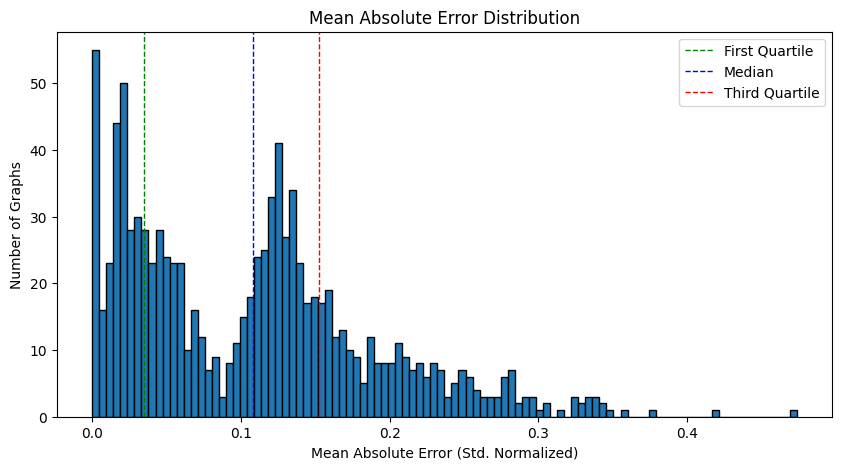

In [204]:
mae_per_graph = {}
for i in range(len(gt_properties)):
    normalized_mae = np.mean(np.abs(np.array(gt_properties[i]) - np.array(predicted_properties[i])) * properties_weights)
    mae_per_graph[i] = normalized_mae

plt.figure(figsize=(10, 5))
plt.hist(mae_per_graph.values(), bins=100, edgecolor='black')
plt.xlabel("Mean Absolute Error (Std. Normalized)")
plt.ylabel("Number of Graphs")
plt.title("Mean Absolute Error Distribution")

first_quartile = np.quantile(list(mae_per_graph.values()), 0.25)
median = np.median(list(mae_per_graph.values()))
third_quartile = np.quantile(list(mae_per_graph.values()), 0.75)

plt.axvline(first_quartile, color='g', linestyle='dashed', linewidth=1, label='First Quartile')
# plt.text(first_quartile+0.005, 50, '25%', color='g')
plt.axvline(median, color='b', linestyle='dashed', linewidth=1, label='Median')
# plt.text(median+0.005, 50, '50%', color='b')
plt.axvline(third_quartile, color='r', linestyle='dashed', linewidth=1, label='Third Quartile')
# plt.text(third_quartile+0.005, 50, '75%', color='r')
plt.legend()
plt.show()

We can look at the generated graphs with highest MAE:

In [205]:
N = 5

mae_per_graph_sorted = dict(sorted(mae_per_graph.items(), key=lambda item: item[1], reverse=True))
gt_prop_highest_mae = []

print(f'Top {N} graphs with highest MAE:')
for i, (graph_id, mae) in enumerate(mae_per_graph_sorted.items()):
    if i == N:
        break
    gt_prop = gt_properties[graph_id]
    gt_prop_highest_mae.append(np.array(gt_prop))
    print(f"Graph ID: {graph_id}, MAE: {mae:.2f}")
    print(f"Ground truth properties: {gt_prop}")
    print(f"Predicted properties:    {predicted_properties[graph_id]}")
    mae_per_prop = np.array(properties_weights)*np.abs(np.array(gt_properties[graph_id]) - np.array(predicted_properties[graph_id]))
    print(f"MAE per property:        {[float(round(m,3)) for m in mae_per_prop]}")
    print()

print('Properties: ', properties)
print('Average: ', [ "{:0.2f}".format(x) for x in np.mean(gt_prop_highest_mae, axis=0)])

Top 5 graphs with highest MAE:
Graph ID: 603, MAE: 0.47
Ground truth properties: [47.0, 132.0, 5.617021083831787, 127.0, 0.12302228063344955, 3.0, 2.0]
Predicted properties:    [49.0, 108.0, 4.408163265306122, 55.0, 0.0978067575577949, 4.0, 6.0]
MAE per property:        [0.17, 0.103, 0.119, 0.026, 0.078, 0.1, 2.721]

Graph ID: 497, MAE: 0.42
Ground truth properties: [48.0, 47.0, 1.9583333730697632, 0.0, 0.0, 1.0, 7.0]
Predicted properties:    [40.0, 37.0, 1.85, 4.0, 0.24, 2.0, 9.0]
MAE per property:        [0.681, 0.043, 0.011, 0.001, 0.743, 0.1, 1.361]

Graph ID: 672, MAE: 0.38
Ground truth properties: [40.0, 39.0, 1.9500000476837158, 0.0, 0.0, 1.0, 7.0]
Predicted properties:    [32.0, 36.0, 2.25, 3.0, 0.14754098360655737, 2.0, 5.0]
MAE per property:        [0.681, 0.013, 0.029, 0.001, 0.457, 0.1, 1.361]

Graph ID: 685, MAE: 0.36
Ground truth properties: [50.0, 211.0, 8.4399995803833, 405.0, 0.27401894330978394, 7.0, 4.0]
Predicted properties:    [49.0, 152.0, 6.204081632653061, 141.0

Properties with the highest (normalized) error for these graphs: 
- number of nodes
- global_clustering_coefficient
- max_k_core
- num_communities

With the lowest MAE: 

In [206]:
mae_per_graph_sorted = dict(sorted(mae_per_graph.items(), key=lambda item: item[1], reverse=False))
gt_prop_lowest_mae = []

print(f'Top {N} graphs with lowest MAE:')
for i, (graph_id, mae) in enumerate(mae_per_graph_sorted.items()):
    if i == N:
        break
    gt_prop = gt_properties[graph_id]
    gt_prop_lowest_mae.append(np.array(gt_prop))
    print(f"Graph ID: {graph_id}, MAE: {mae:.2f}")
    print(f"Ground truth properties: {gt_prop}")
    print(f"Predicted properties:    {predicted_properties[graph_id]}")
    mae_per_prop = np.array(properties_weights)*np.abs(np.array(gt_properties[graph_id]) - np.array(predicted_properties[graph_id]))
    print(f"MAE per property:        {[float(round(m,3)) for m in mae_per_prop]}")
    print()

print('Properties: ', properties)
print('Average: ', [ "{:0.2f}".format(x) for x in np.mean(gt_prop_lowest_mae, axis=0)])

Top 5 graphs with lowest MAE:
Graph ID: 71, MAE: 0.00
Ground truth properties: [13.0, 78.0, 12.0, 286.0, 1.0, 12.0, 1.0]
Predicted properties:    [13.0, 78.0, 12.0, 286.0, 1.0, 12.0, 1.0]
MAE per property:        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Graph ID: 244, MAE: 0.00
Ground truth properties: [14.0, 91.0, 13.0, 364.0, 1.0, 13.0, 1.0]
Predicted properties:    [14.0, 91.0, 13.0, 364.0, 1.0, 13.0, 1.0]
MAE per property:        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Graph ID: 455, MAE: 0.00
Ground truth properties: [20.0, 190.0, 19.0, 1140.0, 1.0, 19.0, 1.0]
Predicted properties:    [20.0, 190.0, 19.0, 1140.0, 1.0, 19.0, 1.0]
MAE per property:        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Graph ID: 471, MAE: 0.00
Ground truth properties: [21.0, 210.0, 20.0, 1330.0, 1.0, 20.0, 1.0]
Predicted properties:    [21.0, 210.0, 20.0, 1330.0, 1.0, 20.0, 1.0]
MAE per property:        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Graph ID: 576, MAE: 0.00
Ground truth properties: [19.0, 171.0, 18.0, 969.0, 1.

We can more precisely look at different quantiles: 

In [221]:
def print_avg_properties_quantile(mae_per_graph, gt_properties, properties, quantile=0.05):
    first_quantile = np.quantile(list(mae_per_graph.values()), quantile)
    third_quantile = np.quantile(list(mae_per_graph.values()), 1-quantile)

    values_before_first_quantile = {k: v for k, v in mae_per_graph.items() if v <= first_quantile}
    values_after_third_quantile = {k: v for k, v in mae_per_graph.items() if v >= third_quantile}

    gt_prop_first_quantile = [np.array(gt_properties[graph_id]) for graph_id in values_before_first_quantile.keys()]
    gt_prop_third_quantile = [np.array(gt_properties[graph_id]) for graph_id in values_after_third_quantile.keys()]

    print(f'Quantile: {quantile}')
    print(f'Number of graphs: {len(values_before_first_quantile)}')
    print('Properties: ', properties)
    print('Average (<q): ', [ "{:0.2f}".format(x) for x in np.mean(gt_prop_first_quantile, axis=0)])
    print('Average (>1-q): ', [ "{:0.2f}".format(x) for x in np.mean(gt_prop_third_quantile, axis=0)])
    return

In [223]:
print_avg_properties_quantile(mae_per_graph, gt_properties, properties, quantile=0.01)

Quantile: 0.01
Number of graphs: 11
Properties:  ['num_nodes', 'num_edges', 'avg_degree', 'num_triangles', 'global_clustering_coefficient', 'k_core', 'num_communities']
Average (<q):  ['18.18', '127.91', '14.45', '685.73', '0.91', '14.45', '2.36']
Average (>1-q):  ['42.10', '115.00', '5.05', '373.40', '0.11', '3.70', '5.80']


In [222]:
print_avg_properties_quantile(mae_per_graph, gt_properties, properties, quantile=0.05)

Quantile: 0.05
Number of graphs: 50
Properties:  ['num_nodes', 'num_edges', 'avg_degree', 'num_triangles', 'global_clustering_coefficient', 'k_core', 'num_communities']
Average (<q):  ['25.56', '133.04', '9.78', '770.16', '0.73', '12.36', '2.06']
Average (>1-q):  ['39.14', '246.16', '11.31', '1770.52', '0.27', '9.50', '4.52']


In [224]:
print_avg_properties_quantile(mae_per_graph, gt_properties, properties, quantile=0.1)

Quantile: 0.1
Number of graphs: 100
Properties:  ['num_nodes', 'num_edges', 'avg_degree', 'num_triangles', 'global_clustering_coefficient', 'k_core', 'num_communities']
Average (<q):  ['26.74', '149.67', '10.51', '811.32', '0.69', '11.78', '2.56']
Average (>1-q):  ['35.71', '216.04', '10.87', '1462.46', '0.30', '9.15', '4.26']


We can also calculate the normalized MAE for each property:

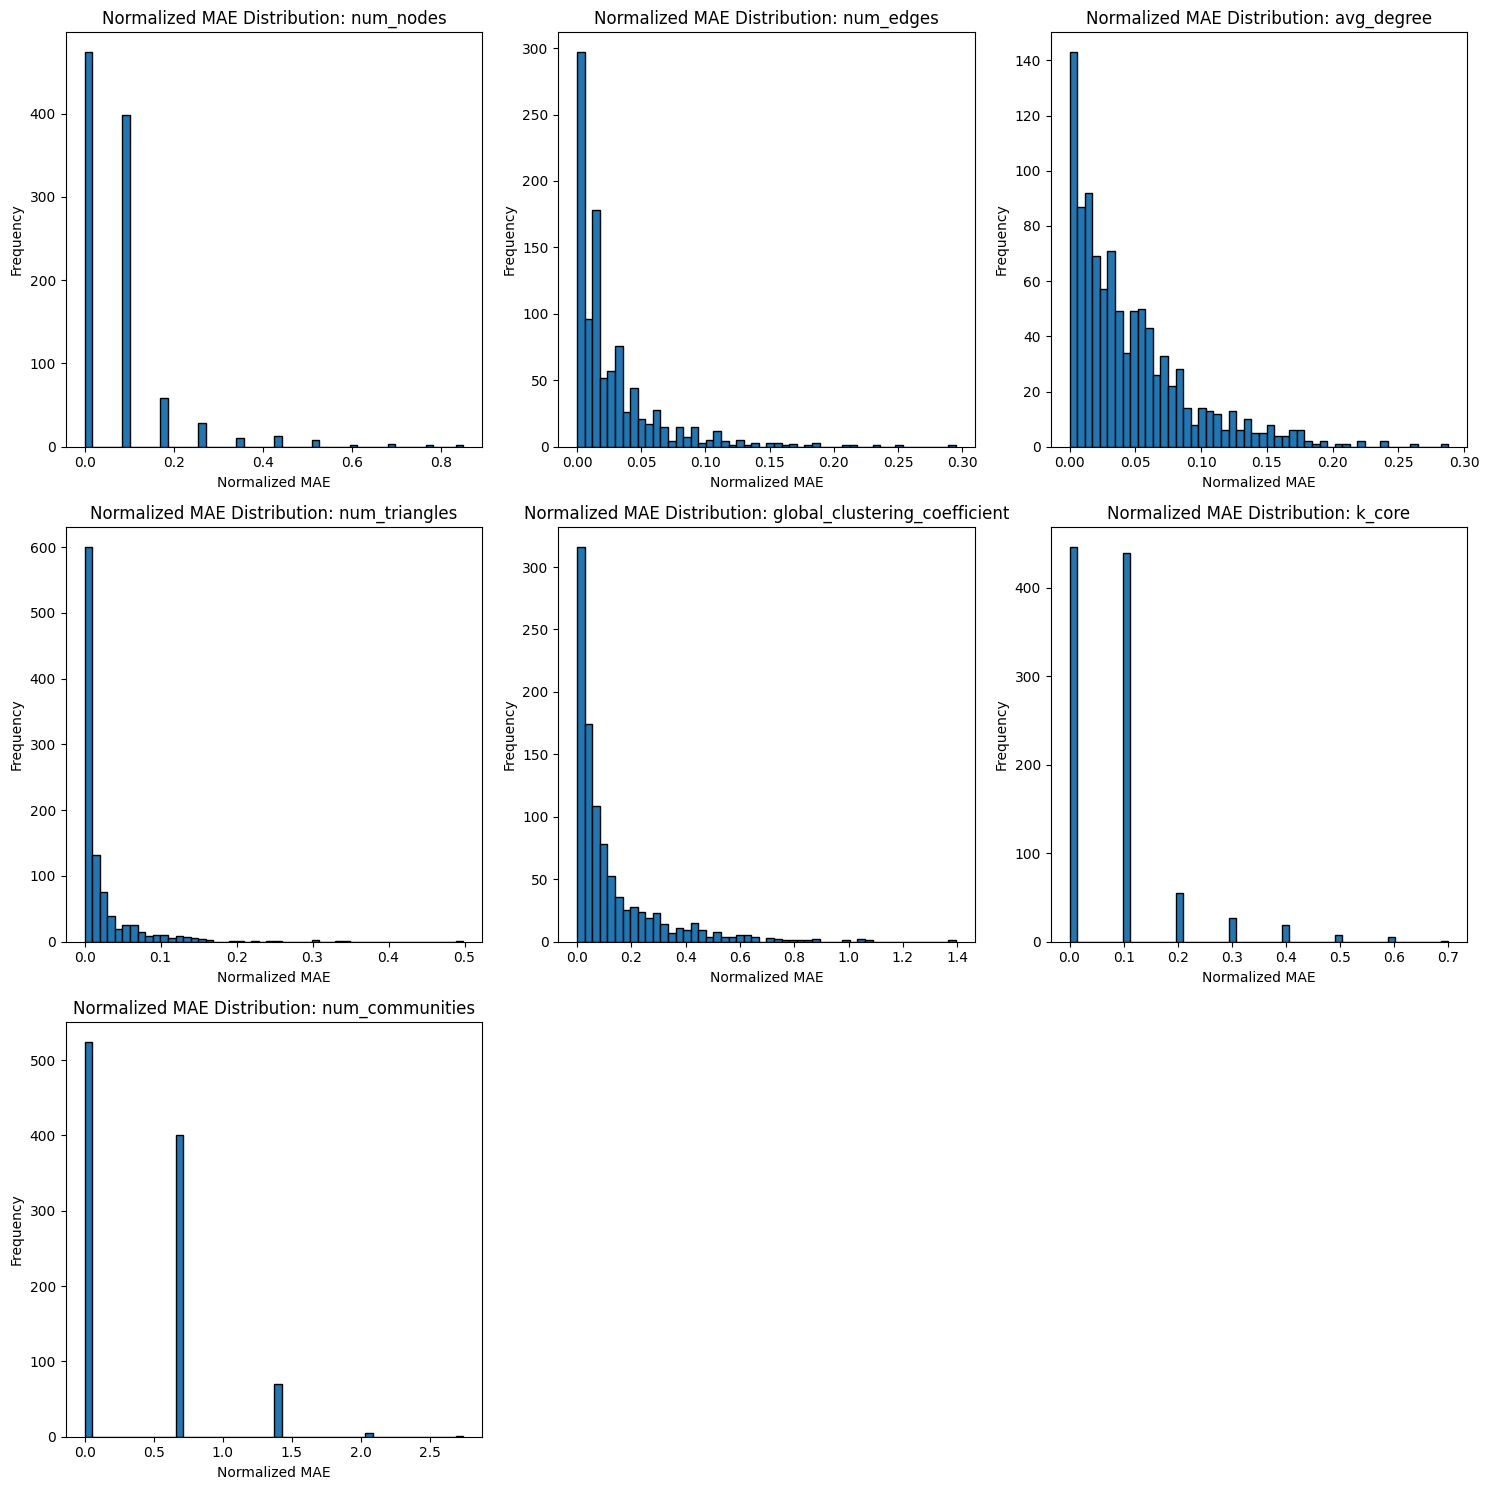

In [141]:
normalized_mae_per_property = {}
for i, property in enumerate(properties):
    normalized_mae_per_property[property] = np.abs(np.array(gt_properties)[:, i] - np.array(predicted_properties)[:, i]) / global_statistics_df.loc[property, 'std']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, (property, normalized_mae) in enumerate(normalized_mae_per_property.items()):
    axes[i].hist(normalized_mae, bins=50, edgecolor='black')
    axes[i].set_title(f'Normalized MAE Distribution: {property}')
    axes[i].set_xlabel('Normalized MAE')
    axes[i].set_ylabel('Frequency')

for j in range(len(properties), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [253]:
print('Number of graphs with num_communities normalized MAE > 0.65:', (normalized_mae_per_property['num_communities'] > 0.65).sum())

Number of graphs with num_communities normalized MAE > 0.65: 476


The number of communities seems especially hard to correctly generate.

## Examples of Generated Graphs

### Test Set

Graph ID: 745
    Property: num_nodes --> GT: 34.00, Predicted: 34.00 -- MAE: 0.00
    Property: num_edges --> GT: 529.00, Predicted: 531.00 -- MAE: 0.01
    Property: avg_degree --> GT: 31.12, Predicted: 31.24 -- MAE: 0.01
    Property: num_triangles --> GT: 5456.00, Predicted: 5431.00 -- MAE: 0.01
    Property: global_clustering_coefficient --> GT: 1.00, Predicted: 0.99 -- MAE: 0.02
    Property: k_core --> GT: 32.00, Predicted: 31.00 -- MAE: 0.10
    Property: num_communities --> GT: 2.00, Predicted: 2.00 -- MAE: 0.00
Global MAE (std normalization): 0.02


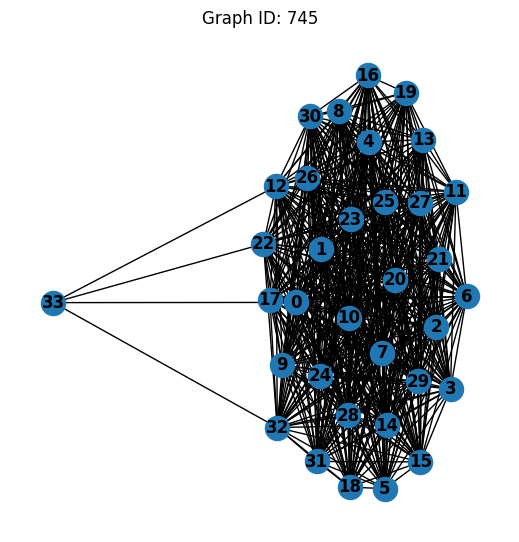

Graph ID: 182
    Property: num_nodes --> GT: 25.00, Predicted: 25.00 -- MAE: 0.00
    Property: num_edges --> GT: 173.00, Predicted: 175.00 -- MAE: 0.01
    Property: avg_degree --> GT: 13.84, Predicted: 14.00 -- MAE: 0.02
    Property: num_triangles --> GT: 433.00, Predicted: 456.00 -- MAE: 0.01
    Property: global_clustering_coefficient --> GT: 0.57, Predicted: 0.59 -- MAE: 0.06
    Property: k_core --> GT: 11.00, Predicted: 11.00 -- MAE: 0.00
    Property: num_communities --> GT: 3.00, Predicted: 3.00 -- MAE: 0.00
Global MAE (std normalization): 0.01


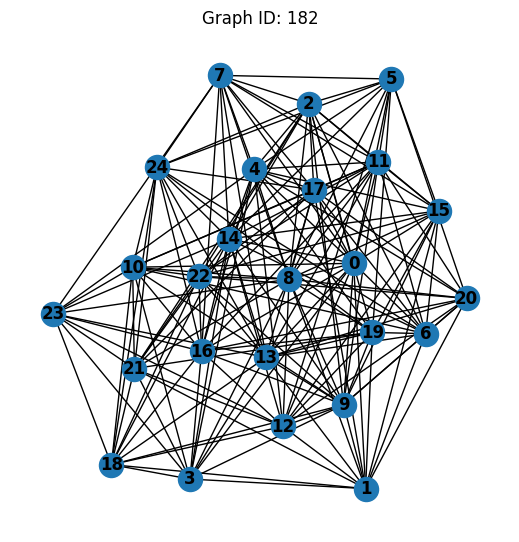

Graph ID: 895
    Property: num_nodes --> GT: 20.00, Predicted: 19.00 -- MAE: 0.09
    Property: num_edges --> GT: 19.00, Predicted: 20.00 -- MAE: 0.00
    Property: avg_degree --> GT: 1.90, Predicted: 2.11 -- MAE: 0.02
    Property: num_triangles --> GT: 0.00, Predicted: 2.00 -- MAE: 0.00
    Property: global_clustering_coefficient --> GT: 0.00, Predicted: 0.20 -- MAE: 0.62
    Property: k_core --> GT: 1.00, Predicted: 2.00 -- MAE: 0.10
    Property: num_communities --> GT: 4.00, Predicted: 5.00 -- MAE: 0.68
Global MAE (std normalization): 0.22


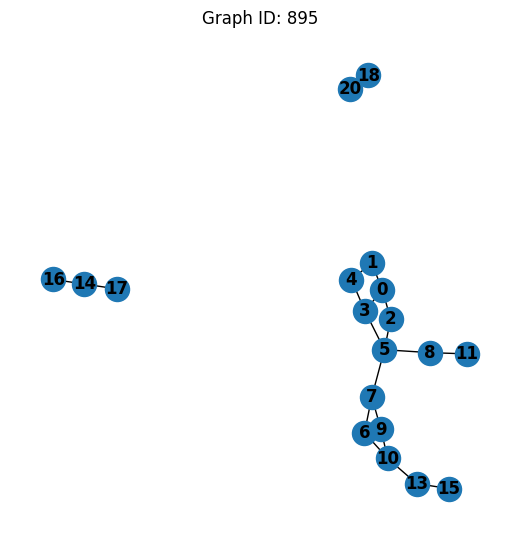

Graph ID: 843
    Property: num_nodes --> GT: 25.00, Predicted: 25.00 -- MAE: 0.00
    Property: num_edges --> GT: 144.00, Predicted: 145.00 -- MAE: 0.00
    Property: avg_degree --> GT: 11.52, Predicted: 11.60 -- MAE: 0.01
    Property: num_triangles --> GT: 680.00, Predicted: 681.00 -- MAE: 0.00
    Property: global_clustering_coefficient --> GT: 0.99, Predicted: 0.98 -- MAE: 0.02
    Property: k_core --> GT: 16.00, Predicted: 16.00 -- MAE: 0.00
    Property: num_communities --> GT: 2.00, Predicted: 2.00 -- MAE: 0.00
Global MAE (std normalization): 0.00


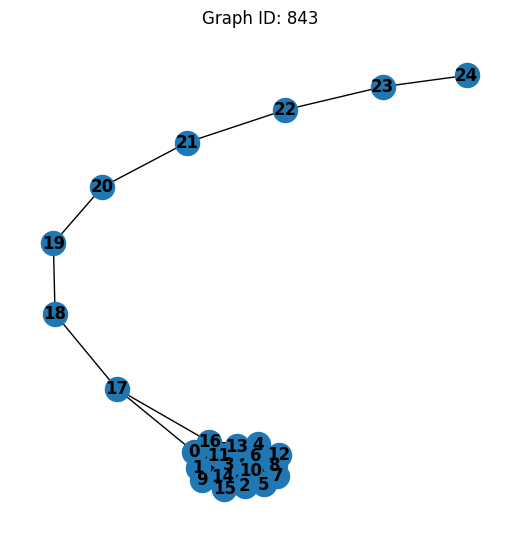

In [ ]:
# # Graphs with low number of nodes and edges for better visualization
# idxs = [7, 17, 28, 32]

# Random indices for visualization
idxs = np.random.choice(len(gt_properties), 4)

for idx in idxs:
    print(f"Graph ID: {idx}")
    mae_per_property = np.array(properties_weights)*np.abs(np.array(gt_properties[idx]) - np.array(predicted_properties[idx]))
    for i, property in enumerate(properties):
        print(f"    Property: {property} --> GT: {gt_properties[idx][i]:.2f}, Predicted: {predicted_properties[idx][i]:.2f} -- MAE: {mae_per_property[i]:.2f}")
    print(f"Global MAE (std normalization): {mae_per_graph[idx]:.2f}")

    G = generated_graphs[idx]
    plt.figure(figsize=(5, 5))
    nx.draw(G, with_labels=True, font_weight='bold')
    plt.title(f"Graph ID: {idx}")
    plt.show()